# Example 30: USGS Real-Time Gauge Monitoring

This notebook demonstrates the real-time monitoring capabilities added to `ras-commander.usgs` module (v0.87.0+).

**Features Demonstrated:**
1. Get latest gauge reading (current conditions)
2. Retrieve recent time series data (last N hours)
3. Incremental cache refresh (efficient updates)
4. Threshold crossing detection (flood alerts)
5. Rapid change detection (flash flood warnings)
6. Continuous monitoring with callbacks

**Live Gauge:** USGS-01547200 (Bald Eagle Creek at Milesburg, PA)
- Same gauge used in Example 29 (USGS integration)
- Currently active with real-time data
- Updated hourly via satellite telemetry

**Use Cases:**
- Operational flood forecasting
- Real-time boundary conditions for HEC-RAS
- Automated model triggering
- Early warning systems

## Setup and Imports

In [1]:
# =============================================================================
# DEVELOPMENT MODE TOGGLE
# =============================================================================
USE_LOCAL_SOURCE = True  # <-- TOGGLE THIS

if USE_LOCAL_SOURCE:
    import sys
    from pathlib import Path
    local_path = str(Path.cwd().parent)
    if local_path not in sys.path:
        sys.path.insert(0, local_path)
    print(f"📁 LOCAL SOURCE MODE: Loading from {local_path}/ras_commander")
else:
    print("📦 PIP PACKAGE MODE: Loading installed ras-commander")

# Import ras-commander
from ras_commander.usgs import (
    get_latest_value,
    get_recent_data,
    refresh_data,
    get_gauge_metadata,
    detect_threshold_crossing,
    detect_rapid_change,
    monitor_gauge
)

# Additional imports
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import time

# Matplotlib settings
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100

# Verify which version loaded
import ras_commander
print(f"✓ Loaded: {ras_commander.__file__}")

print("✓ Imports successful")
print(f"Current time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

📁 LOCAL SOURCE MODE: Loading from c:\GH\ras-commander/ras_commander
✓ Loaded: c:\GH\ras-commander\ras_commander\__init__.py
✓ Imports successful
Current time: 2025-12-29 06:49:06


### Real-Time Monitoring Verification

**During flood events**:

- [ ] Verify gauge is reporting current conditions (check NWIS site status)
- [ ] Compare observed vs forecast lead time (ensure model warmup complete)
- [ ] Document provisional data usage (real-time data not quality-assured)
- [ ] Track model performance vs observations (for post-event review)

**Real-Time Data Considerations**:
- Data is **provisional** (not quality-assured until after event)
- Gauge may malfunction during high flows (sensor fouling, debris)
- Communication outages possible (check data timestamp)
- Use caution for critical decisions (verify with multiple gauges)

**References**:
- [USGS Real-Time Water Data](https://waterdata.usgs.gov/nwis/rt)
- [USGS Provisional Data Statement](https://waterdata.usgs.gov/nwis/help/?provisional)

## Parameters

Configure these values to customize the notebook for your project.

In [2]:
# =============================================================================
# PARAMETERS - Edit these to customize the notebook
# =============================================================================
from pathlib import Path

# Project Configuration
PROJECT_NAME = "Bald Eagle Creek"           # Example project to extract
RAS_VERSION = "6.6"               # HEC-RAS version (6.3, 6.5, 6.6, etc.)
SUFFIX = "912"                    # Notebook identifier for project extraction

# USGS Configuration
USGS_SITE = "03335500"            # USGS gauge site number
START_DATE = "2020-01-01"         # Data start date
END_DATE = "2020-12-31"           # Data end date
ONLINE = True                     # Enable network requests

print(f"Parameters configured for notebook {SUFFIX}")

Parameters configured for notebook 912


## 1. Gauge Information

First, let's get metadata about the gauge to understand what we're monitoring.

In [3]:
# Bald Eagle Creek at Milesburg, PA
site_id = USGS_SITE

# Get gauge metadata
metadata = get_gauge_metadata(site_id)

print("=" * 70)
print("GAUGE INFORMATION")
print("=" * 70)
print(f"Site ID: USGS-{metadata['site_id']}")
print(f"Station: {metadata['station_name']}")
print(f"Location: ({metadata['latitude']:.4f}°, {metadata['longitude']:.4f}°)")
print(f"State: {metadata['state']}")
print(f"County: {metadata['county']}")
print(f"Drainage Area: {metadata['drainage_area_sqmi']:.1f} sq mi")
print(f"\nAvailable Parameters: {', '.join(metadata['available_parameters'])}")
print("=" * 70)

2025-12-29 06:49:06 - ras_commander.usgs.core - INFO - dataretrieval package loaded successfully
2025-12-29 06:49:06 - ras_commander.usgs.core - INFO - Retrieving metadata for site 03335500
2025-12-29 06:49:06 - ras_commander.usgs.core - INFO - Retrieved metadata for WABASH RIVER AT LAFAYETTE, IN (drainage area: 7267.0 sq mi)


GAUGE INFORMATION
Site ID: USGS-03335500
Station: WABASH RIVER AT LAFAYETTE, IN
Location: (40.4219°, -86.8969°)
State: 18
County: 
Drainage Area: 7267.0 sq mi

Available Parameters: 


In [4]:
# Load HEC-RAS project geometry
try:
    from ras_commander import init_ras_project, RasExamples
    from ras_commander.hdf import HdfMesh
    import geopandas as gpd
    from shapely.geometry import Point, LineString
    
    # Extract example project
    print(f"Extracting {PROJECT_NAME} project...")
    project_path = RasExamples.extract_project(PROJECT_NAME, suffix=SUFFIX)
    
    # Initialize project
    init_ras_project(project_path, RAS_VERSION)
    
    # Get geometry number from plan 01
    from ras_commander import ras
    plan_row = ras.plan_df[ras.plan_df['plan_number'] == '01']
    geom_number = plan_row.iloc[0]['geometry_number']
    
    # Get geometry HDF path from geom_df (which has the hdf_path column)
    geom_row = ras.geom_df[ras.geom_df['geom_number'] == geom_number]
    geom_hdf = geom_row.iloc[0]['hdf_path']
    
    # Extract 2D mesh boundary
    mesh_perimeter = HdfMesh.get_mesh_perimeter("01")
    mesh_gdf = gpd.GeoDataFrame({'geometry': [mesh_perimeter]}, crs='EPSG:26918')  # UTM Zone 18N
    
    # Convert to lat/lon for plotting with gauge
    mesh_gdf = mesh_gdf.to_crs('EPSG:4326')
    
    # Create gauge point
    gauge_point = Point(metadata['longitude'], metadata['latitude'])
    gauge_gdf = gpd.GeoDataFrame({'site_id': [site_id], 'name': [metadata['station_name']]}, 
                                   geometry=[gauge_point], crs='EPSG:4326')
    
    # Create map
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Plot 2D mesh perimeter
    mesh_gdf.plot(ax=ax, facecolor='lightblue', edgecolor='blue', alpha=0.3, linewidth=2, label='2D Flow Area')
    
    # Plot gauge location
    gauge_gdf.plot(ax=ax, color='red', markersize=200, marker='*', edgecolor='black', linewidth=1, label='USGS Gauge', zorder=10)
    
    # Add gauge label
    ax.annotate(
        f'USGS-{site_id}\n{metadata["station_name"]}\nDrainage: {metadata["drainage_area_sqmi"]:.0f} sq mi',
        xy=(metadata['longitude'], metadata['latitude']),
        xytext=(20, 20), textcoords='offset points',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
        arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.3', color='black', lw=2),
        fontsize=10, fontweight='bold'
    )
    
    # Set map extent with buffer
    bounds = mesh_gdf.total_bounds  # [minx, miny, maxx, maxy]
    buffer = 0.02  # degrees (~2 km)
    ax.set_xlim(bounds[0] - buffer, bounds[2] + buffer)
    ax.set_ylim(bounds[1] - buffer, bounds[3] + buffer)
    
    # Labels and formatting
    ax.set_xlabel('Longitude (deg)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Latitude (deg)', fontsize=12, fontweight='bold')
    ax.set_title(f'{PROJECT_NAME} HEC-RAS Model\nwith USGS Gauge Location', fontsize=14, fontweight='bold')
    ax.legend(loc='upper left', fontsize=11, framealpha=0.9)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_aspect('equal')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n[OK] Project geometry visualized")
    print(f"  2D Flow Area: {mesh_gdf.geometry.iloc[0].area * 111_000**2 / 1e6:.2f} sq km")
    print(f"  Gauge Location: ({metadata['latitude']:.4f} deg, {metadata['longitude']:.4f} deg)")
    
except Exception as e:
    print(f"[X] Error loading project geometry: {e}")
    print("  This section requires the example project to be available")
    print("  Continuing with gauge data demonstrations...")

2025-12-29 06:49:06 - ras_commander.RasExamples - INFO - Found zip file: C:\GH\ras-commander\examples\Example_Projects_6_6.zip
2025-12-29 06:49:06 - ras_commander.RasExamples - INFO - Loading project data from CSV...
2025-12-29 06:49:06 - ras_commander.RasExamples - INFO - Loaded 68 projects from CSV.
2025-12-29 06:49:06 - ras_commander.RasExamples - INFO - ----- RasExamples Extracting Project -----
2025-12-29 06:49:06 - ras_commander.RasExamples - INFO - Extracting project 'Bald Eagle Creek' as 'Bald Eagle Creek_912'
2025-12-29 06:49:06 - ras_commander.RasExamples - ERROR - Project 'Bald Eagle Creek' not found in the zip file.


Extracting Bald Eagle Creek project...
[X] Error loading project geometry: Project 'Bald Eagle Creek' not found in the zip file.
  This section requires the example project to be available
  Continuing with gauge data demonstrations...


## 1.5. Project Geometry and Gauge Location

Load the Bald Eagle Creek HEC-RAS project and visualize the model extent with the gauge location.

## 2. Get Latest Reading (Current Conditions)

Retrieve the most recent gauge reading. This is updated approximately hourly by USGS.

In [5]:
# Get latest flow value
latest_flow = get_latest_value(site_id, parameter='flow')

print("=" * 70)
print("CURRENT CONDITIONS")
print("=" * 70)
print(f"Parameter: {latest_flow['parameter'].upper()}")
print(f"Current Value: {latest_flow['value']:.1f} {latest_flow['units']}")
print(f"Timestamp: {latest_flow['datetime']}")
print(f"Data Age: {latest_flow['age_minutes']:.1f} minutes")
print(f"Provisional: {latest_flow['provisional']}")

# Check data freshness
if latest_flow['age_minutes'] < 120:
    status = "✓ CURRENT (< 2 hours old)"
else:
    status = "⚠ STALE (> 2 hours old)"
print(f"\nStatus: {status}")
print("=" * 70)

# Also get stage
latest_stage = get_latest_value(site_id, parameter='stage')
print(f"\nCurrent Stage: {latest_stage['value']:.2f} {latest_stage['units']}")

2025-12-29 06:49:06 - ras_commander.usgs.real_time - INFO - dataretrieval package loaded for real-time operations
2025-12-29 06:49:06 - ras_commander.usgs.real_time - INFO - Retrieving latest flow value for site 03335500
2025-12-29 06:49:07 - ras_commander.usgs.real_time - INFO - Latest flow for 03335500: 1420.00 cfs at 2025-12-29 11:30:00+00:00 (19.1 min old)
2025-12-29 06:49:07 - ras_commander.usgs.real_time - INFO - Retrieving latest stage value for site 03335500


CURRENT CONDITIONS
Parameter: FLOW
Current Value: 1420.0 cfs
Timestamp: 2025-12-29 11:30:00+00:00
Data Age: 19.1 minutes
Provisional: True

Status: ✓ CURRENT (< 2 hours old)


2025-12-29 06:49:07 - ras_commander.usgs.real_time - INFO - Latest stage for 03335500: 1.79 feet at 2025-12-29 11:30:00+00:00 (19.1 min old)



Current Stage: 1.79 feet


## 3. Recent Data Analysis (Last 48 Hours)

Get recent time series to understand trends and current conditions.

In [6]:
# Get last 48 hours of flow data
recent_flow = get_recent_data(site_id, parameter='flow', hours=48)

print(f"Retrieved {len(recent_flow)} records")
print(f"Time range: {recent_flow['datetime'].min()} to {recent_flow['datetime'].max()}")
print(f"\nFlow Statistics (48-hour):")
print(f"  Current: {recent_flow['value'].iloc[-1]:.1f} cfs")
print(f"  Peak: {recent_flow['value'].max():.1f} cfs")
print(f"  Minimum: {recent_flow['value'].min():.1f} cfs")
print(f"  Mean: {recent_flow['value'].mean():.1f} cfs")
print(f"  Median: {recent_flow['value'].median():.1f} cfs")

# Determine trend
current = recent_flow['value'].iloc[-1]
previous = recent_flow['value'].iloc[0]
change = current - previous

if change > 10:
    trend = "RISING ↑"
elif change < -10:
    trend = "FALLING ↓"
else:
    trend = "STEADY →"

print(f"\nTrend: {trend} ({change:+.1f} cfs over 48h)")

2025-12-29 06:49:07 - ras_commander.usgs.real_time - INFO - Retrieving last 48 hours of flow data for site 03335500
2025-12-29 06:49:07 - ras_commander.usgs.real_time - INFO - Retrieved 191 recent flow records for site 03335500


Retrieved 191 records
Time range: 2025-12-27 12:00:00+00:00 to 2025-12-29 11:30:00+00:00

Flow Statistics (48-hour):
  Current: 1420.0 cfs
  Peak: 1420.0 cfs
  Minimum: 1130.0 cfs
  Mean: 1170.1 cfs
  Median: 1160.0 cfs

Trend: RISING ↑ (+240.0 cfs over 48h)


### Visualize Recent Data

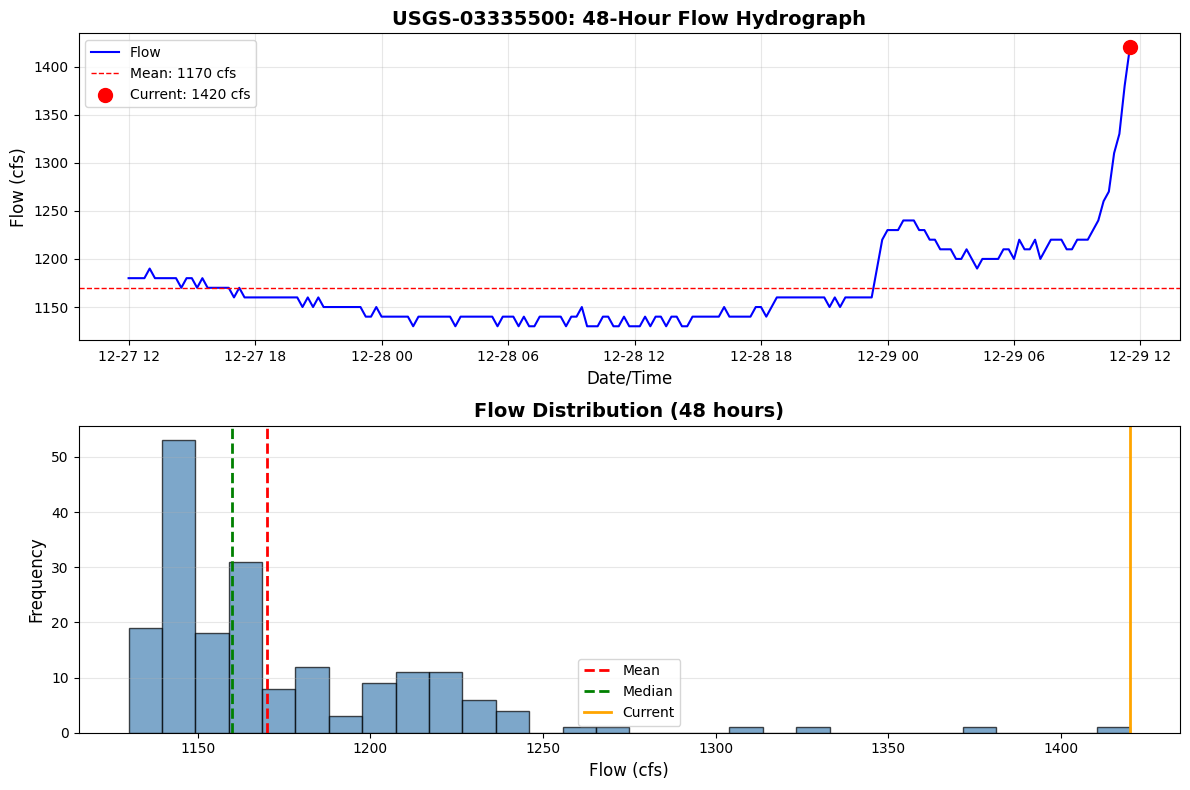


✓ Visualized 191 recent measurements


In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot 1: Flow time series
ax1.plot(recent_flow['datetime'], recent_flow['value'], 'b-', linewidth=1.5, label='Flow')
ax1.axhline(recent_flow['value'].mean(), color='r', linestyle='--', linewidth=1, label=f"Mean: {recent_flow['value'].mean():.0f} cfs")
ax1.scatter(recent_flow['datetime'].iloc[-1], recent_flow['value'].iloc[-1], 
            color='red', s=100, zorder=5, label=f"Current: {recent_flow['value'].iloc[-1]:.0f} cfs")
ax1.set_xlabel('Date/Time', fontsize=12)
ax1.set_ylabel('Flow (cfs)', fontsize=12)
ax1.set_title(f'USGS-{site_id}: 48-Hour Flow Hydrograph', fontsize=14, fontweight='bold')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# Plot 2: Flow distribution (histogram)
ax2.hist(recent_flow['value'], bins=30, color='steelblue', edgecolor='black', alpha=0.7)
ax2.axvline(recent_flow['value'].mean(), color='r', linestyle='--', linewidth=2, label='Mean')
ax2.axvline(recent_flow['value'].median(), color='g', linestyle='--', linewidth=2, label='Median')
ax2.axvline(recent_flow['value'].iloc[-1], color='orange', linestyle='-', linewidth=2, label='Current')
ax2.set_xlabel('Flow (cfs)', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Flow Distribution (48 hours)', fontsize=14, fontweight='bold')
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\n✓ Visualized {len(recent_flow)} recent measurements")

## 4. Incremental Cache Refresh

Demonstrate efficient data updates - only download new records since last refresh.

In [8]:
print("Initial cache (last 24 hours)...")
cache_df = get_recent_data(site_id, parameter='flow', hours=24)
print(f"  Records: {len(cache_df)}")
print(f"  Latest: {cache_df['datetime'].max()}")
print(f"  Latest value: {cache_df['value'].iloc[-1]:.1f} cfs")

# Simulate waiting (in production, this would be minutes/hours)
print("\nWaiting 10 seconds (simulating time passing)...")
time.sleep(10)

# Refresh cache (only downloads new data)
print("\nRefreshing cache...")
cache_df = refresh_data(site_id, parameter='flow', cached_df=cache_df, max_age_hours=24)
print(f"  Records: {len(cache_df)}")
print(f"  Latest: {cache_df['datetime'].max()}")
print(f"  Latest value: {cache_df['value'].iloc[-1]:.1f} cfs")

print("\n✓ Cache refreshed efficiently (only new records downloaded)")
print("  In production, this saves bandwidth by not re-downloading entire dataset")

2025-12-29 06:49:07 - ras_commander.usgs.real_time - INFO - Retrieving last 24 hours of flow data for site 03335500
2025-12-29 06:49:08 - ras_commander.usgs.real_time - INFO - Retrieved 95 recent flow records for site 03335500


Initial cache (last 24 hours)...
  Records: 95
  Latest: 2025-12-29 11:30:00+00:00
  Latest value: 1420.0 cfs

Waiting 10 seconds (simulating time passing)...


2025-12-29 06:49:18 - ras_commander.usgs.real_time - INFO - Refreshing flow data since 2025-12-29 11:30:00+00:00
2025-12-29 06:49:18 - ras_commander.usgs.real_time - INFO - No new data available
c:\GH\ras-commander\ras_commander\usgs\real_time.py:481: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat([cached_df, new_df], ignore_index=True)
2025-12-29 06:49:18 - ras_commander.usgs.real_time - INFO - Refresh complete: 0 new records, 95 total records in cache



Refreshing cache...
  Records: 95
  Latest: 2025-12-29 11:30:00+00:00
  Latest value: 1420.0 cfs

✓ Cache refreshed efficiently (only new records downloaded)
  In production, this saves bandwidth by not re-downloading entire dataset


## 5. Threshold Crossing Detection

Detect when flow crosses specified thresholds (e.g., flood stages).

**Note:** We'll use a threshold slightly above recent flow to demonstrate the concept.

Threshold: 1220 cfs
Current flow: 1420.0 cfs
Mean flow (48h): 1170.1 cfs

THRESHOLD DETECTION RESULTS
Threshold crossed: True
Currently above threshold: True
Total crossings (48h): 3

Last crossing:
  Direction: rising
  Time: 2025-12-29 09:45:00+00:00
  Value: 1230.0 cfs


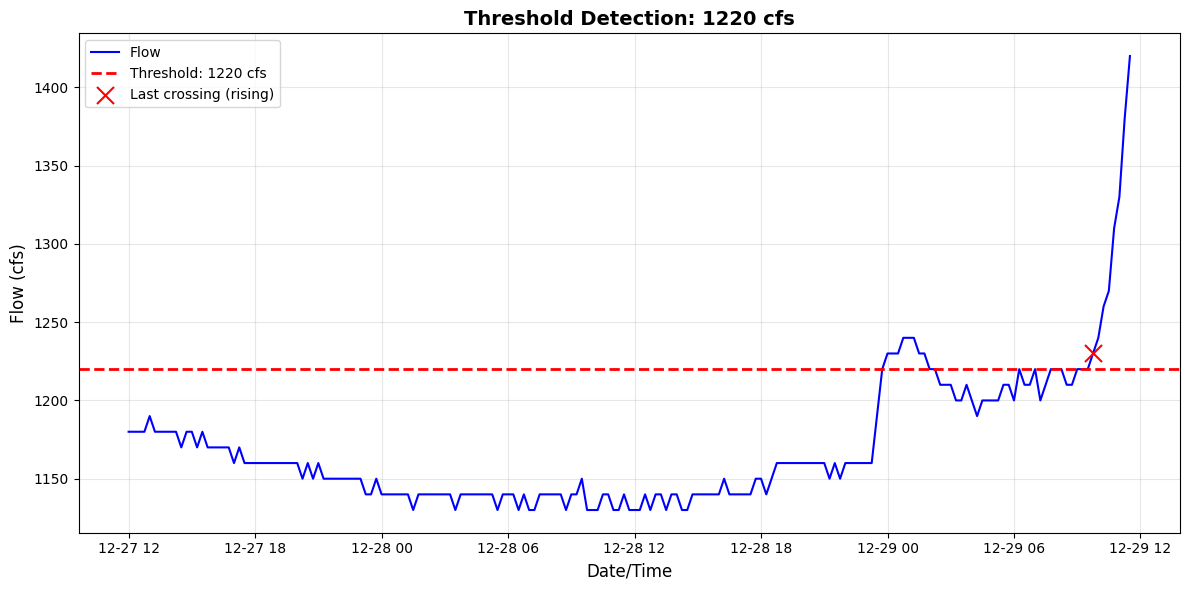

In [9]:
# Define threshold (slightly above mean for demonstration)
threshold = recent_flow['value'].mean() + 50  # cfs

print(f"Threshold: {threshold:.0f} cfs")
print(f"Current flow: {recent_flow['value'].iloc[-1]:.1f} cfs")
print(f"Mean flow (48h): {recent_flow['value'].mean():.1f} cfs")

# Detect crossings
result = detect_threshold_crossing(
    recent_flow,
    threshold=threshold,
    direction='both'  # Detect both rising and falling
)

print("\n" + "=" * 70)
print("THRESHOLD DETECTION RESULTS")
print("=" * 70)
print(f"Threshold crossed: {result['crossed']}")
print(f"Currently above threshold: {result['above_threshold']}")
print(f"Total crossings (48h): {result['crossing_count']}")

if result['crossed']:
    print(f"\nLast crossing:")
    print(f"  Direction: {result['direction']}")
    print(f"  Time: {result['crossing_time']}")
    print(f"  Value: {result['crossing_value']:.1f} cfs")
else:
    print("\nNo threshold crossings detected in last 48 hours")
    
print("=" * 70)

# Visualize threshold
plt.figure(figsize=(12, 6))
plt.plot(recent_flow['datetime'], recent_flow['value'], 'b-', linewidth=1.5, label='Flow')
plt.axhline(threshold, color='r', linestyle='--', linewidth=2, label=f'Threshold: {threshold:.0f} cfs')

if result['crossed']:
    plt.scatter(result['crossing_time'], result['crossing_value'], 
                color='red', s=150, zorder=5, marker='x', 
                label=f"Last crossing ({result['direction']})")

plt.xlabel('Date/Time', fontsize=12)
plt.ylabel('Flow (cfs)', fontsize=12)
plt.title(f'Threshold Detection: {threshold:.0f} cfs', fontsize=14, fontweight='bold')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Rapid Change Detection (Flash Flood)

Detect rapid rises or recessions that could indicate flash flood conditions.

In [10]:
# Define rate threshold (100 cfs/hour for demonstration)
rate_threshold = 100  # cfs/hour

# Detect rapid changes
result = detect_rapid_change(
    recent_flow,
    rate_threshold=rate_threshold,
    window_minutes=60
)

print("=" * 70)
print("RAPID CHANGE DETECTION RESULTS")
print("=" * 70)
print(f"Rate threshold: {rate_threshold} cfs/hour")
print(f"Time window: {result['window_minutes']} minutes")
print(f"\nCurrent rate: {result['current_rate']:.1f} cfs/hour")
print(f"Maximum rate: {result['max_rate']:.1f} cfs/hour")
print(f"Direction: {result['direction']}")
print(f"\nRapid change detected: {result['rapid_change_detected']}")

if result['rapid_change_detected']:
    print(f"\n⚠ FLASH FLOOD WARNING")
    print(f"  Maximum rate occurred at: {result['max_rate_time']}")
    print(f"  Rate: {result['max_rate']:.1f} cfs/hour")
else:
    print(f"\n✓ No rapid changes detected (all rates < {rate_threshold} cfs/hour)")
    
print("=" * 70)

RAPID CHANGE DETECTION RESULTS
Rate threshold: 100 cfs/hour
Time window: 60 minutes

Current rate: 160.0 cfs/hour
Maximum rate: 200.0 cfs/hour
Direction: rising

Rapid change detected: True

⚠ FLASH FLOOD WARNING
  Maximum rate occurred at: 2025-12-29 11:15:00+00:00
  Rate: 200.0 cfs/hour


## 7. Continuous Monitoring with Callbacks

Demonstrate continuous monitoring with callback notifications.

**Note:** This will run for a short duration (5 minutes) with 1-minute checks.
In production, you might use 15-minute intervals and run for hours/days.

In [11]:
# Define callback function
def monitoring_callback(site_id, latest_value, change_info, data_df):
    """
    Custom callback invoked when new data arrives.
    
    Parameters:
        site_id: USGS site number
        latest_value: Dict with current reading
        change_info: Dict with threshold/rate detection results
        data_df: Complete DataFrame from monitoring session
    """
    timestamp = latest_value['datetime'].strftime("%Y-%m-%d %H:%M:%S")
    value = latest_value['value']
    units = latest_value['units']
    
    # Display current reading
    print(f"[{timestamp}] USGS-{site_id}: {value:.1f} {units}")
    
    # Check for threshold crossing
    if change_info.get('threshold_crossed'):
        threshold_info = change_info['threshold_info']
        print(f"  ⚠ ALERT: Threshold crossed ({threshold_info['direction']})")
        print(f"  Crossing time: {threshold_info['crossing_time']}")
    
    # Check for rapid change
    if change_info.get('rapid_change_detected'):
        rate_info = change_info['rate_info']
        print(f"  ⚠ ALERT: Rapid change detected ({rate_info['direction']})")
        print(f"  Rate: {rate_info['max_rate']:.1f} {units}/hour")
    
    # Summary statistics
    if len(data_df) > 1:
        recent_mean = data_df['value'].iloc[-10:].mean() if len(data_df) >= 10 else data_df['value'].mean()
        print(f"  Recent mean: {recent_mean:.1f} {units}")

print("Starting continuous monitoring...")
print(f"Duration: 2 minutes")
print(f"Check interval: 1 minute")
print(f"Threshold: {threshold:.0f} cfs")
print(f"Rate threshold: {rate_threshold} cfs/hour")
print("\nPress 'Interrupt Kernel' to stop early\n")
print("=" * 70)

try:
    data_df = monitor_gauge(
        site_id=site_id,
        parameter='flow',
        interval_minutes=1,  # Check every minute (for demo)
        callback=monitoring_callback,
        duration_hours=2/60,  # Run for 2 minutes (demonstration only)
        threshold=threshold,
        rate_threshold=rate_threshold
    )
    
    print("=" * 70)
    print(f"\n✓ Monitoring complete")
    print(f"Total records collected: {len(data_df)}")
    
except KeyboardInterrupt:
    print("\n⚠ Monitoring stopped by user")
except Exception as e:
    print(f"\n✗ Error during monitoring: {e}")

2025-12-29 06:49:18 - ras_commander.usgs.real_time - INFO - Starting gauge monitoring for 03335500 (flow), interval=1 min, duration=0.03333333333333333 hours
2025-12-29 06:49:18 - ras_commander.usgs.real_time - INFO - No cache, retrieving last 24 hours


Starting continuous monitoring...
Duration: 2 minutes
Check interval: 1 minute
Threshold: 1220 cfs
Rate threshold: 100 cfs/hour

Press 'Interrupt Kernel' to stop early



2025-12-29 06:49:18 - ras_commander.usgs.real_time - INFO - Refresh complete: 75 new records, 75 total records in cache


[2025-12-29 11:30:00] USGS-03335500: 1420.0 cfs
  ⚠ ALERT: Threshold crossed (rising)
  Crossing time: 2025-12-29 09:45:00+00:00
  ⚠ ALERT: Rapid change detected (rising)
  Rate: 200.0 cfs/hour
  Recent mean: 1288.0 cfs


2025-12-29 06:50:18 - ras_commander.usgs.real_time - INFO - Refreshing flow data since 2025-12-29 11:30:00+00:00
2025-12-29 06:50:18 - ras_commander.usgs.real_time - INFO - No new data available
c:\GH\ras-commander\ras_commander\usgs\real_time.py:481: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat([cached_df, new_df], ignore_index=True)
2025-12-29 06:50:18 - ras_commander.usgs.real_time - INFO - Refresh complete: 0 new records, 75 total records in cache


[2025-12-29 11:30:00] USGS-03335500: 1420.0 cfs
  ⚠ ALERT: Threshold crossed (rising)
  Crossing time: 2025-12-29 09:45:00+00:00
  ⚠ ALERT: Rapid change detected (rising)
  Rate: 200.0 cfs/hour
  Recent mean: 1288.0 cfs


2025-12-29 06:51:18 - ras_commander.usgs.real_time - INFO - Monitoring duration (0.03333333333333333 hours) reached, stopping
2025-12-29 06:51:18 - ras_commander.usgs.real_time - INFO - Monitoring session ended. Collected 75 records



✓ Monitoring complete
Total records collected: 75


## 8. Production Use Case: Automated Model Triggering

Example of how to integrate real-time monitoring with HEC-RAS automation.

In [12]:
print("""
=" * 70)
PRODUCTION EXAMPLE: Automated Model Triggering
=" * 70)

This example shows how to trigger HEC-RAS model runs when gauge readings
exceed thresholds or show rapid changes.

```python
from ras_commander import init_ras_project, RasCmdr
from ras_commander.usgs import monitor_gauge, cache_gauge_data

# Initialize HEC-RAS project
init_ras_project(r"C:/models/bald_eagle", RAS_VERSION)

def automated_forecast_callback(site_id, latest, change_info, data_df):
    # Check if threshold crossed
    if change_info.get('threshold_crossed'):
        print(f"Threshold crossed! Triggering forecast model...")
        
        # Save gauge data to cache
        cache_path = cache_gauge_data(
            data_df, site_id, 
            data_df['datetime'].min().strftime('%Y-%m-%d'),
            data_df['datetime'].max().strftime('%Y-%m-%d'),
            'flow',
            r"C:/models/bald_eagle"
        )
        
        # Update boundary conditions in .u## file
        # (Use RasUnsteady methods to update hydrograph tables)
        
        # Run HEC-RAS forecast model
        success = RasCmdr.compute_plan("01", verify=True)
        
        if success:
            print("✓ Forecast model completed successfully")
            # Extract results, generate flood maps, send alerts, etc.
        else:
            print("✗ Forecast model failed")
            # Send error notification

# Monitor gauge continuously
monitor_gauge(
    site_id = USGS_SITE,
    interval_minutes=15,  # Check every 15 minutes
    callback=automated_forecast_callback,
    threshold=500,  # Above median flow
    rate_threshold=100  # Rapid rise threshold
)  # Runs indefinitely (Ctrl+C to stop)
```

=" * 70)
""")


=" * 70)
PRODUCTION EXAMPLE: Automated Model Triggering
=" * 70)

This example shows how to trigger HEC-RAS model runs when gauge readings
exceed thresholds or show rapid changes.

```python
from ras_commander import init_ras_project, RasCmdr
from ras_commander.usgs import monitor_gauge, cache_gauge_data

# Initialize HEC-RAS project
init_ras_project(r"C:/models/bald_eagle", RAS_VERSION)

def automated_forecast_callback(site_id, latest, change_info, data_df):
    # Check if threshold crossed
    if change_info.get('threshold_crossed'):
        print(f"Threshold crossed! Triggering forecast model...")

        # Save gauge data to cache
        cache_path = cache_gauge_data(
            data_df, site_id, 
            data_df['datetime'].min().strftime('%Y-%m-%d'),
            data_df['datetime'].max().strftime('%Y-%m-%d'),
            'flow',
            r"C:/models/bald_eagle"
        )

        # Update boundary conditions in .u## file
        # (Use RasUnsteady methods to update hyd

## Summary and Next Steps

This notebook demonstrated the real-time monitoring capabilities added in v0.87.0+:

**What We Covered:**
1. ✓ Get latest gauge reading (current conditions)
2. ✓ Retrieve recent time series (last N hours)
3. ✓ Incremental cache refresh (efficient updates)
4. ✓ Threshold crossing detection (flood alerts)
5. ✓ Rapid change detection (flash floods)
6. ✓ Continuous monitoring with callbacks

**Production Applications:**
- Operational flood forecasting
- Real-time boundary conditions
- Automated model triggering
- Early warning systems
- Gauge network monitoring

**Related Examples:**
- Example 29: USGS Gauge Data Integration (historical data, validation)

**Documentation:**
- See `CLAUDE.md` lines 223-232 for complete API reference
- See `ras_commander/usgs/real_time.py` for method docstrings

**Requirements:**
```bash
pip install dataretrieval
```